
# Module 1. Training from Local Environment using GluonTS
---

본 모듈에서는 GluonTS를 사용하여 시계열 데이터에 대한 훈련 및 추론을 수행해 보겠습니다.
노트북 실행에는 2~3분 소요되지만, 핸즈온 실습 시에는 25분을 권장드립니다. 특히 시계열 데이터, pandas, GluonTS를 다루는 데 익숙하지 않으면 각 코드 셀별로 실행시켜 보시는 것을 추천드립니다.

이 데이터셋은 미국 미네아폴리스 서쪽 방향 고속도로(I-94)의 2012년~2018년 차량 통행량을 **시간 단위**로 예측하는 데이터셋입니다. `store-item-demand` 데이터셋과 달리 결측 시계열들이 있고 연관 시계열 데이터도 존재하기 때문에 간단한 데이터 전처리를 수행 후에 `target time series` 와 `related time series` 로 훈련 및 예측을 수행하겠습니다.

### References
- Dataset description: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume
- Amazon Forecast 핸즈온: https://github.com/chrisking/ForecastPOC
- Amazon Forecast 핸즈온(한국어): https://github.com/gonsoomoon-ml/Forecast/tree/master/TrafficVolume
- GluonTS: https://gluon-ts.mxnet.io

## 1. Setup
---
만약 GluonTS가 인스톨되어 있지 않다면, 아래 코드 셀의 주석을 해제하고 코드 셀을 실행시켜 주세요.

In [1]:
#! pip install gluonts==0.6.7

### Import Libraries
표준 Python 라이브러리를 가져옵니다.

In [2]:
import os
import pandas as pd
import gluonts 
import numpy as np
import argparse
import json
import pathlib
from mxnet import gpu, cpu
from mxnet.context import num_gpus
import matplotlib.pyplot as plt

from gluonts.dataset.util import to_pandas
from gluonts.mx.distribution import DistributionOutput, StudentTOutput, NegativeBinomialOutput, GaussianOutput
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics
from gluonts.model.predictor import Predictor
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

<br>

## 2. Data Loading & Checking
---

판매 데이터를 판다스 데이터프레임으로 로딩합니다. 데이터프레임 로딩 후, 날짜 컬럼을 `datetime` 포맷의 컬럼으로 변경합니다. 본 예제는 데이터 사이즈가 크지 않기에 차이를 느끼기 어렵겠지만, 수천 만개의 행을 그대로 `datetime` 으로 변환하면 모든 행을 순회해야 하기에 시간이 오래 소요됩니다. 따라서, 고유한 날짜만 `datetime`으로 변환하여 `map()`으로 그룹 매핑하면 빠르게 변환할 수 있습니다.

In [3]:
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
!cd $data_dir && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!gunzip -f $data_dir/Metro_Interstate_Traffic_Volume.csv.gz #-f means not to ask Yes or No
original_data = pd.read_csv(data_dir + '/Metro_Interstate_Traffic_Volume.csv')

--2021-04-07 05:29:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K  1.39MB/s    in 0.3s    

2021-04-07 05:29:57 (1.39 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



데이터셋 각 컬럼의 의미는 아래와 같습니다.
- `holiday` : 미국 공휴일 및 지역별 공휴일, 미네소타 주 박람회
- `rain_1h` : 한 시간 내에 발생한 강우량 (mm)
- `snow_1h` : 한 시간 내에 발생한 강설량 (mm)
- `clouds_all` : 구름량의 백분율
- `weather_main` : 현재 날씨 (범주형)
- `weather_description` : 현재 날씨에 대한 설명 (범주형)
- `date_time` : 현지 CST 시간으로 수집 된 데이터의 시간
- `traffic_volume` : 교통량

In [4]:
display(original_data.head(10))
print(original_data.shape)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


(48204, 9)


Start Date:  2012-10-02 09:00:00
End Date:  2018-09-30 23:00:00


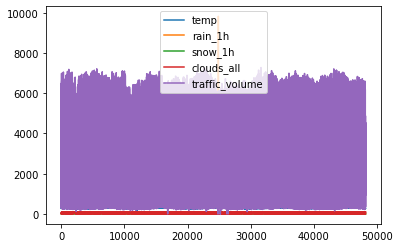

In [5]:
df = original_data.copy()
df.plot()
print("Start Date: ", min(df['date_time']))
print("End Date: ", max(df['date_time']))

상기 코드 셀에서 2012년 10월부터 2018년 10월까지의 시간별 데이터를 확인할 수 있으며, 일부 시계열 데이터가 누락된 것을 확인할 수 있습니다. (1년에 약 8700시간이 있다는 점을 감안할 때 약 52,000개의 시계얼 데이터가 있어야 하므로)

In [6]:
total_days = 2190
# Build the index first
idx = pd.date_range(start='10/02/2012', end='09/30/2018', freq='H')
full_df = pd.DataFrame(index=idx)
full_df.shape

(52537, 0)

In [7]:
df.set_index('date_time', inplace=True)
df = df.drop_duplicates(keep ='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48175 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48175 non-null  object 
 1   temp                 48175 non-null  float64
 2   rain_1h              48175 non-null  float64
 3   snow_1h              48175 non-null  float64
 4   clouds_all           48175 non-null  int64  
 5   weather_main         48175 non-null  object 
 6   weather_description  48175 non-null  object 
 7   traffic_volume       48175 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [8]:
# Now perform the join
full_historical_df = full_df.join(df, how='outer')
print (full_historical_df.index.min())
print (full_historical_df.index.max())

2012-10-02 00:00:00
2018-09-30 23:00:00


데이터를 살펴 보면 2014년 말부터 2016년 중반까지 시계열 데이터가 누락되어 있습니다.

<AxesSubplot:>

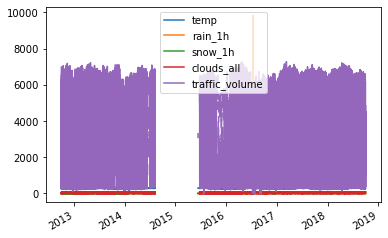

In [9]:
full_historical_df.plot()

In [10]:
# Take a look at 10 random entries
full_historical_df.sample(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-07-26 10:00:00,None,295.58,0.0,0.0,90.0,Rain,light rain,4467.0
2017-11-18 20:00:00,None,269.44,0.0,0.0,5.0,Clear,sky is clear,3181.0
2014-12-24 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-07-27 00:00:00,None,296.63,0.0,0.0,75.0,Clouds,broken clouds,622.0
2014-08-13 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-19 01:00:00,None,293.49,0.0,0.0,1.0,Clear,sky is clear,423.0
2018-07-03 06:00:00,None,294.04,0.0,0.0,1.0,Rain,light rain,5264.0
2014-04-01 05:00:00,None,268.93,0.0,0.0,90.0,Clouds,overcast clouds,2577.0
2018-05-30 09:00:00,None,293.15,0.0,0.0,90.0,Rain,light rain,5283.0
2012-10-18 01:00:00,None,282.80,0.0,0.0,40.0,Clouds,scattered clouds,374.0


자세한 내용은 생략하였지만 간단하게 EDA를 수행해 보면, 2013년과 2016년에도 일부 누락된 시계열이 있습니다. 

물론 전체 데이터로 다 훈련을 수행할 수도 있지만, 최근 1-2년치 데이터로 훈련하는 것이 충분한 경우가 많고 2017~2018년의 시계열은 안정적으로 분포되어 있기 때문에 본 예제에서는 2017년 1월 1일 데이터부터 사용하겠습니다.

<br>

## 3. Data Wrangling
---

Amazon Forecast는 csv 파일을 입력데이터로 지원하지만, 대부분의 경우 raw 데이터를 그대로 사용할 수 없습니다. Forecast 뿐만 아니라, SageMaker built-in DeepAR이나 GluonTS도 마찬가지이므로 전처리 작업은 필수입니다. 대표적인 데이터 전처리 예시들은 아래와 같습니다.

- 중복 제거
- 이상치 제거 or padding (예: 수량 예측 시 0보다 작은 값이 포함된 경우 0으로 padding)
- Daily/Weekly Aggregation (Mean, Sum, Min, Max 등)
- Missing date padding 
- Missing data imputation
- 범주형 데이터의 label ncoding, one-hot encoding

본 데이터셋은 Aggregation, Missing date padding, label encoding으로 간단한 전처리를 수행합니다.

In [11]:
# Create a copy
df = full_historical_df.copy()
# Slice to only 2017 onward
df = df.loc['2017-01-01':]
# Validate the dates
print (df.index.min())
print (df.index.max())

2017-01-01 00:00:00
2018-09-30 23:00:00


여전히 일부 누락된 데이터가 있기 때문에 backward filling과 forward filling으로 결측치를 보충해 줍니다.

In [12]:
# Fill in any missing data with the method ffill
df.bfill(inplace=True)
df.ffill()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
2017-01-01 00:00:00,None,269.75,0.0,0.0,75.0,Clouds,broken clouds,1848.0
2017-01-01 01:00:00,None,269.95,0.0,0.0,1.0,Clear,sky is clear,1806.0
2017-01-01 02:00:00,None,269.75,0.0,0.0,1.0,Clear,sky is clear,1211.0
2017-01-01 03:00:00,None,269.65,0.0,0.0,40.0,Clouds,scattered clouds,794.0
2017-01-01 04:00:00,None,269.48,0.0,0.0,1.0,Clear,sky is clear,500.0
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75.0,Clouds,broken clouds,3543.0
2018-09-30 20:00:00,None,282.76,0.0,0.0,90.0,Clouds,overcast clouds,2781.0
2018-09-30 21:00:00,None,282.73,0.0,0.0,90.0,Thunderstorm,proximity thunderstorm,2159.0
2018-09-30 22:00:00,None,282.09,0.0,0.0,90.0,Clouds,overcast clouds,1450.0


### Label Encoding

범주형 데이터를 수치형으로 변환해줍니다.

In [13]:
cat_dict = {}
cat_cols = ['holiday', 'weather_main', 'weather_description']
for c in cat_cols:
    df[c], cat_dict[c] = pd.factorize(df[c]) 

### Create Target time-series and Related time-series

In [14]:
FREQ = 'H'
df = df.resample(FREQ).sum()
target_col = 'traffic_volume'
related_cols = ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']
target_df = df[[target_col]]
related_df = df[related_cols]

In [15]:
target_df.head()

,traffic_volume
2017-01-01 00:00:00,1848.0
2017-01-01 01:00:00,1806.0
2017-01-01 02:00:00,1211.0
2017-01-01 03:00:00,794.0
2017-01-01 04:00:00,500.0


훈련 데이터와 테스트 데이터를 분리합니다.

In [16]:
target_train_df = target_df.loc['2017-01-01':'2018-07-31']
target_test_df = target_df.loc['2018-08-01':]

related_train_df = related_df.loc['2017-01-01':'2018-07-31']
related_test_df = related_df.loc['2018-08-01':]

간단하게 시계열 데이터를 확인해 봅니다.

<AxesSubplot:title={'center':'Hourly Traffic Volume in Dec 2017'}>

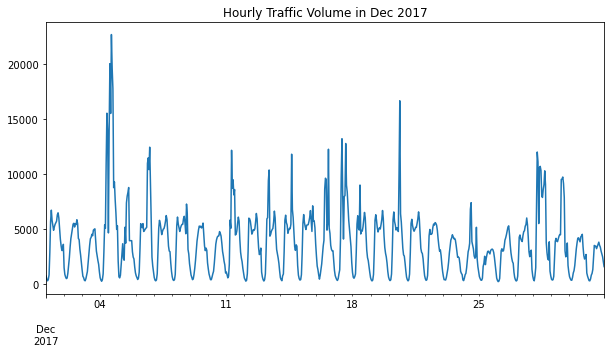

In [17]:
target_train_df['2017-12-01':'2017-12-31']['traffic_volume'].resample(FREQ).sum().plot(title="Hourly Traffic Volume in Dec 2017", figsize=(10,5))

In [18]:
related_train_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
2017-01-01 00:00:00,0,269.75,0.0,0.0,75.0,0,0
2017-01-01 01:00:00,0,269.95,0.0,0.0,1.0,1,1
2017-01-01 02:00:00,0,269.75,0.0,0.0,1.0,1,1
2017-01-01 03:00:00,0,269.65,0.0,0.0,40.0,0,2
2017-01-01 04:00:00,0,269.48,0.0,0.0,1.0,1,1


<AxesSubplot:title={'center':'Hourly Traffic Volume in Dec 2017'}>

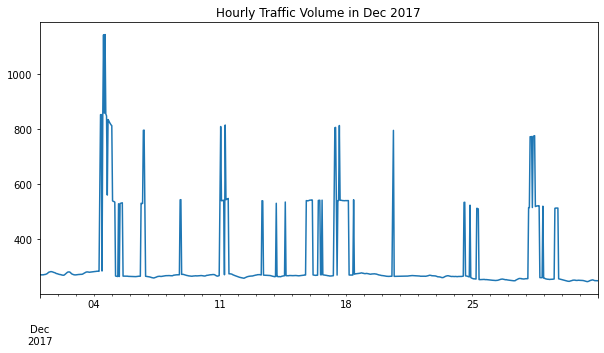

In [19]:
related_train_df['2017-12-01':'2017-12-31']['temp'].resample(FREQ).sum().plot(title="Hourly Traffic Volume in Dec 2017", figsize=(10,5))

<AxesSubplot:title={'center':'Hourly Traffic Volume in Dec 2017'}>

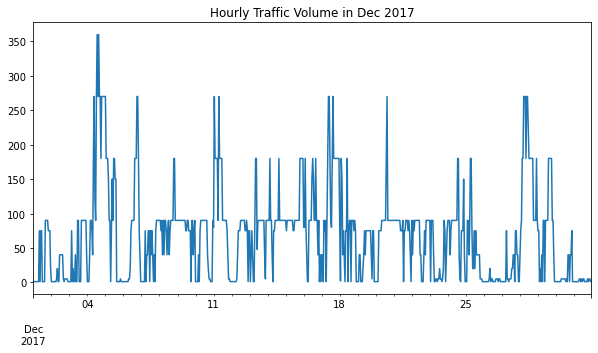

In [20]:
related_train_df['2017-12-01':'2017-12-31']['clouds_all'].resample(FREQ).sum().plot(title="Hourly Traffic Volume in Dec 2017", figsize=(10,5))

### Save preprocessed data

전처리가 완료된 데이터를 다음 모듈에서 그대로 활용하기 위해 csv로 저장합니다.

In [21]:
target_train_df.to_csv(f'{data_dir}/target_train.csv', index=True)
target_test_df.to_csv(f'{data_dir}/target_test.csv', index=True)

related_train_df.to_csv(f'{data_dir}/related_train.csv', index=True)
related_test_df.to_csv(f'{data_dir}/related_test.csv', index=True)

<br>

## 4. Preparing GlounTS Dataset
---

7일치 데이터(24 x 7 = 168)를 예측 구간으로 설정합니다.

In [22]:
num_steps, num_series = target_train_df.shape
target = target_train_df.values

pred_length = 24*7 
start_train_dt = '2017-01-01 00:00:00'
custom_ds_metadata = {'num_series': num_series,
                      'num_steps': num_steps,
                      'prediction_length': pred_length,
                      'freq': FREQ,
                      'start': start_train_dt
                     }

### Create GluonTS Dataset

GluonTS Dataset을 생성하기 위해서는 `FieldName.TARGET`과 `FieldName.START` 키에 해당하는 값들이 반드시 포함되어야 하며, 나머지 FieldName에 대해서는 선택적으로 포함할 수 있습니다.
 
그리고, 일반적인 ML 알고리즘과 달리 GlounTS의 테스트 데이터셋은 훈련 데이터 전부를 포함합니다.
예를 들어 100일치 시계열을 대상으로, 마지막 20일치 데이터에 대해 테스트가 필요한 경우(80일 훈련, 20일 테스트), 
시작일부터 80일치까지의 시계열을 훈련 데이터로 지정하고 100일치의 모든 데이터를 그대로 테스트 데이터셋으로 지정하시면 됩니다. 전체 시계열이 필요한 이유는
Evaluator 클래스를 통해 metric 및 plotting을 한 줄의 코드로 간단하게 수행하기 위함이고, 실제 내부 로직에서는 테스트 시계열에서 예측 시계열 길이만큼의(예: 20일치) 데이터를 잘라내어 추론을 수행합니다.

In [23]:
related_list = [related_train_df[c].values for c in related_cols]
train_lst = []

target_vec = target[:-pred_length].squeeze()
related_vecs = [related[:-pred_length].squeeze() for related in related_list]
dic = {FieldName.TARGET: target_vec, 
       FieldName.START: start_train_dt,
       FieldName.FEAT_DYNAMIC_REAL: related_vecs
      } 
train_lst.append(dic)

test_lst = []

target_vec = target.squeeze()
related_vecs = [related.squeeze() for related in related_list]
dic = {FieldName.TARGET: target_vec, 
       FieldName.START: start_train_dt,
       FieldName.FEAT_DYNAMIC_REAL: related_vecs
      } 
test_lst.append(dic)

train_ds = ListDataset(train_lst, freq=FREQ)
test_ds = ListDataset(test_lst, freq=FREQ)  

<br>

## 5. Baseline Training and Evaluation (Seasonal naïve)
---

머신러닝의 첫번째 iteration은 baseline 모델을 만들어 보는 것입니다. baseline을 통해 모델이 예측하는 하한선(lower bound)을 알 수 있으며, 특히 복잡한 패턴들이 많은 시계열 데이터에서는 baseline이 매우 잘 동작합니다. 

Seasonal naïve는 이전 데이터의 통계치를 반영하는 모델로, 과거 관측치를 복사하기 때문에 복잡한 훈련 과정 수행 없이 곧바로 추론이 가능하다는 장점이 있습니다.

In [24]:
from gluonts.model.seasonal_naive import *
from gluonts.evaluation import Evaluator

naive_predictor = SeasonalNaivePredictor(freq=custom_ds_metadata['freq'], 
                                         prediction_length=pred_length,
                                         season_length=24)

In [25]:
from pylab import rcParams
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

rcParams['figure.figsize'] = 15, 8
    
def plot_forecasts(tss, forecasts, past_length=40, num_plots=2):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()
        
        
def get_metrics(tss, forecasts, num_series, verbose=1):
    evaluator = Evaluator(num_workers=os.cpu_count())
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=num_series)
    metrics = ['RMSE', 'MAPE', 'wQuantileLoss[0.1]', 'wQuantileLoss[0.5]', 'wQuantileLoss[0.9]', 'mean_wQuantileLoss']
    metrics_dic = dict((key,value) for key, value in agg_metrics.items() if key in metrics)
    if verbose == 1:
        print(json.dumps(metrics_dic, indent=4))
    return metrics_dic

In [26]:
forecast_it_baseline, ts_it_baseline = make_evaluation_predictions(test_ds, naive_predictor, num_samples=1)
forecasts_baseline = list(forecast_it_baseline)
tss_baseline = list(ts_it_baseline)

Seasonal naïve도 전반적인 추이를 잘 예측하지만, 갑작스럽게 급증하는 교통량에 대한 예측 능력이 부족합니다. 이를 아래에서 개선해 보겠습니다.

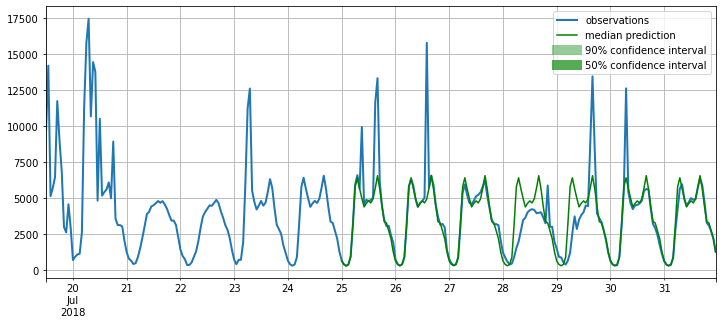

In [27]:
plot_forecasts(tss_baseline, forecasts_baseline, past_length=300, num_plots=1)

In [28]:
metrics_baseline = get_metrics(tss_baseline, forecasts_baseline, len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

{
    "MAPE": 0.24857417424711042,
    "RMSE": 1673.5405866718904,
    "wQuantileLoss[0.1]": 0.18636299230348113,
    "wQuantileLoss[0.5]": 0.20017550639229703,
    "wQuantileLoss[0.9]": 0.21398802048111293,
    "mean_wQuantileLoss": 0.20017550639229706
}


<br>

## 6. Training and Evaluation (SimpleFeedForwardEstimator)
---

SimpleFeedForwardEstimator로 예측을 수행해 보겠습니다.

### Training

In [29]:
device = 'gpu' if num_gpus() > 0 else "cpu"
trainer = Trainer(
    ctx=device,
    epochs=10,
    learning_rate=0.0005,
    num_batches_per_epoch=50
)

In [30]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator

mlp_estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=trainer
)

In [31]:
mlp_predictor = mlp_estimator.train(train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:01<00:00, 49.97it/s, epoch=10/10, avg_epoch_loss=8.55]


### Evaluation

아래 코드 셀에서는 `gluonts.evaluation.Evaluator()`를 사용하여 훈련된 모델의 지표(metirc)들을 생성합니다. 지표들은
딕셔너리와 판다스 데이터프레임의 두 가지 형태들로 반환하며, Evaluator 생성자 호출 시에 필요한 지표들만 명시적으로 지정할 수도 있습니다. 

참고로, 딥러닝 기반 모델은 점예측이 아닌 모수 예측을 통한 샘플링이기 때문에 `make_evaluation_predictions` 함수의 `num_samples`는 자유롭게 부여하시면 됩니다.

In [32]:
forecast_it = mlp_predictor.predict(test_ds)
a = list(forecast_it)
a[0].samples.mean(axis=0).tolist()

[1118.1292724609375,
 493.08746337890625,
 761.1174926757812,
 29.462265014648438,
 1098.3634033203125,
 2379.365234375,
 4132.8662109375,
 5285.9375,
 5530.06982421875,
 4359.4501953125,
 13963.8662109375,
 5619.5751953125,
 4910.669921875,
 5162.49560546875,
 5265.82177734375,
 5848.3935546875,
 5962.53271484375,
 5668.32568359375,
 4601.8935546875,
 3072.985595703125,
 2701.198974609375,
 2577.878173828125,
 1575.4654541015625,
 1238.82666015625,
 535.957275390625,
 1068.3017578125,
 713.071044921875,
 507.47113037109375,
 1422.3760986328125,
 3068.023681640625,
 4434.974609375,
 5336.31494140625,
 5266.642578125,
 5080.0458984375,
 4914.0517578125,
 4870.13525390625,
 5229.48974609375,
 6694.765625,
 5736.98876953125,
 5935.66796875,
 6738.189453125,
 5905.162109375,
 4492.54541015625,
 3451.74853515625,
 3184.552734375,
 3094.781005859375,
 3017.60595703125,
 1040.8118896484375,
 1025.06005859375,
 182.6461181640625,
 -318.39324951171875,
 397.4244384765625,
 1831.0615234375,
 315

In [33]:
%%time
forecast_it, ts_it = make_evaluation_predictions( 
                     dataset=test_ds,  # test dataset
                     predictor=mlp_predictor, # predictor
                     num_samples=100) # number of sample paths we want for evaluation
forecasts = list(forecast_it)
tss = list(ts_it)

CPU times: user 11.1 ms, sys: 334 µs, total: 11.4 ms
Wall time: 7.88 ms


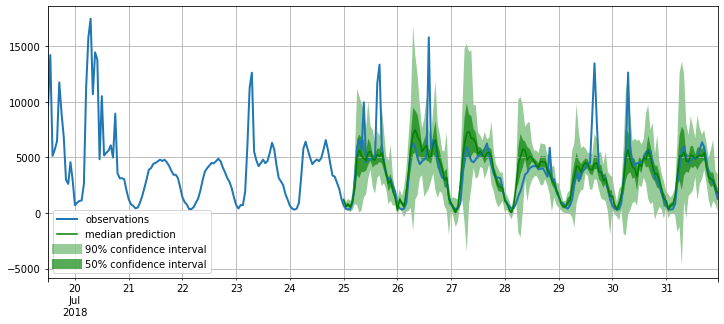

In [34]:
plot_forecasts(tss, forecasts, past_length=300, num_plots=1)

In [35]:
metrics = get_metrics(tss, forecasts, len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

{
    "MAPE": 0.3346472904406769,
    "RMSE": 1740.3493902087591,
    "wQuantileLoss[0.1]": 0.10192888361296018,
    "wQuantileLoss[0.5]": 0.24520622511146203,
    "wQuantileLoss[0.9]": 0.21793996785422806,
    "mean_wQuantileLoss": 0.2099367595707236
}


### Compare with two models

Baseline 모델과 MLP 모델의 성능을 확인해 보겠습니다. 본 데이터셋처럼 주기성이 강한 패턴은 굳이 복잡한 모델을 사용하지 않고 순진한 모델로도 예측을 잘 할 수 있습니다.

In [36]:
metrics_df = pd.concat([pd.Series(metrics_baseline), pd.Series(metrics)], axis=1)
metrics_df.columns=['Baseline', 'MLP']
display(metrics_df)

,Baseline,MLP
MAPE,0.248574,0.334647
RMSE,1673.540587,1740.349390
wQuantileLoss[0.1],0.186363,0.101929
wQuantileLoss[0.5],0.200176,0.245206
wQuantileLoss[0.9],0.213988,0.217940
mean_wQuantileLoss,0.200176,0.209937


<br>

## 7. Miscellaneous
---

### Save the model

모델을 저장합니다. 저장된 모델은 deserialize하여 로딩 가능합니다.

In [37]:
model_dir = 'model'
!rm -rf $model_dir
os.makedirs(model_dir, exist_ok=True)
mlp_predictor.serialize(pathlib.Path(model_dir))